In [1]:
import numpy as np
from scipy.linalg import toeplitz
import vimpy
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import sage
import matplotlib.pyplot as plt
from fippy.explainers import Explainer
from fippy.samplers import GaussianSampler
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd


np.random.seed(12345)
seed=12345

/home/mind/areyerol/.local/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-30 12:30:49,470	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-05-30 12:31:03,787	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [34]:
# Data generation


def sample_gaussian_toeplitz(n, p, rho):
    # Step 1: Create Toeplitz covariance matrix
    cov = toeplitz([rho**i for i in range(p)])
    
    # Step 2: Sample from multivariate normal
    mean = np.zeros(p)
    samples = np.random.multivariate_normal(mean, cov, size=n)
    
    return samples

## -------------------------------------------------------------
## problem setup
## -------------------------------------------------------------
## define a function for the conditional mean of Y given X
def cond_mean(x = None):
    f1 = np.where(np.logical_and(-2 <= x[:, 0], x[:, 0] < 2), np.floor(x[:, 0]), 0)
    f2 = np.where(x[:, 1] <= 0, 1, 0)
    f3 = np.where(x[:, 2] > 0, 1, 0)
    f6 = np.absolute(x[:, 5]/4) ** 3
    f7 = np.absolute(x[:, 6]/4) ** 5
    f11 = (7./3)*np.cos(x[:, 10]/2)
    ret = f1 + f2 + f3 + f6 + f7 + f11
    return ret

## create data
n = 1000
p = 15

x = sample_gaussian_toeplitz(n=n, p=p, rho=0.8)
y = cond_mean(x) + np.random.normal(0, 1, n)

## -------------------------------------------------------------
## preliminary step: get regression estimators
## -------------------------------------------------------------
## use grid search to get optimal number of trees and learning rate
ntrees = np.arange(100, 500, 100)
lr = np.arange(.01, .1, .05)

param_grid = [{'n_estimators':ntrees, 'learning_rate':lr}]

## set up cv objects
cv_full = GridSearchCV(GradientBoostingRegressor(loss = 'squared_error', max_depth = 1), param_grid = param_grid, cv = 5)



In [3]:
# Data generation


def sample_gaussian_toeplitz(n, p, rho):
    # Step 1: Create Toeplitz covariance matrix
    cov = toeplitz([rho**i for i in range(p)])
    
    # Step 2: Sample from multivariate normal
    mean = np.zeros(p)
    samples = np.random.multivariate_normal(mean, cov, size=n)
    
    return samples

## -------------------------------------------------------------
## problem setup
## -------------------------------------------------------------
## define a function for the conditional mean of Y given X
def cond_mean(x = None):
    return x[:, 0] * x[:, 1] * (x[:, 2] > 0) + 2 * x[:, 3] * x[:, 4] * (x[:, 2] <= 0)

## create data
n = 1000
p = 10

x = sample_gaussian_toeplitz(n=n, p=p, rho=0.8)
y = cond_mean(x) + np.random.normal(0, 1, n)

## -------------------------------------------------------------
## preliminary step: get regression estimators
## -------------------------------------------------------------
## use grid search to get optimal number of trees and learning rate
ntrees = np.arange(100, 500, 100)
lr = np.arange(.01, .1, .05)

param_grid = [{'n_estimators':ntrees, 'learning_rate':lr}]

## set up cv objects
cv_full = GridSearchCV(GradientBoostingRegressor(loss = 'squared_error', max_depth = 1), param_grid = param_grid, cv = 5)

In [4]:
loco_w = np.zeros(p)
for j in range(p):
    vimp = vimpy.vim(y = y, x = x, s = 1, pred_func = cv_full, measure_type = "r_squared")
    ## get the point estimate of variable importance
    vimp.get_point_est()
    ## get the influence function estimate
    vimp.get_influence_function()
    ## get a standard error
    vimp.get_se()
    ## get a confidence interval
    vimp.get_ci()
    ## do a hypothesis test, compute p-value
    vimp.hypothesis_test(alpha = 0.05, delta = 0)
    ## display the estimates, etc.
    loco_w[j] = vimp.vimp_

In [5]:
loco_w

array([-0.13073898,  0.06495051, -0.06290758, -0.00902867,  0.06565419,
       -0.04729295,  0.0145513 , -0.02274938,  0.03296771, -0.01418995])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)
cv_full.fit(X_train, y_train)

# Best model
model = cv_full.best_estimator_
# Setup and calculate
imputer = sage.MarginalImputer(model, X_train)
estimator = sage.PermutationEstimator(imputer, "mse")
sage_values = estimator(X_test, y_test)

100%|██████████| 1/1 [09:59<00:00, 599.42s/it]     


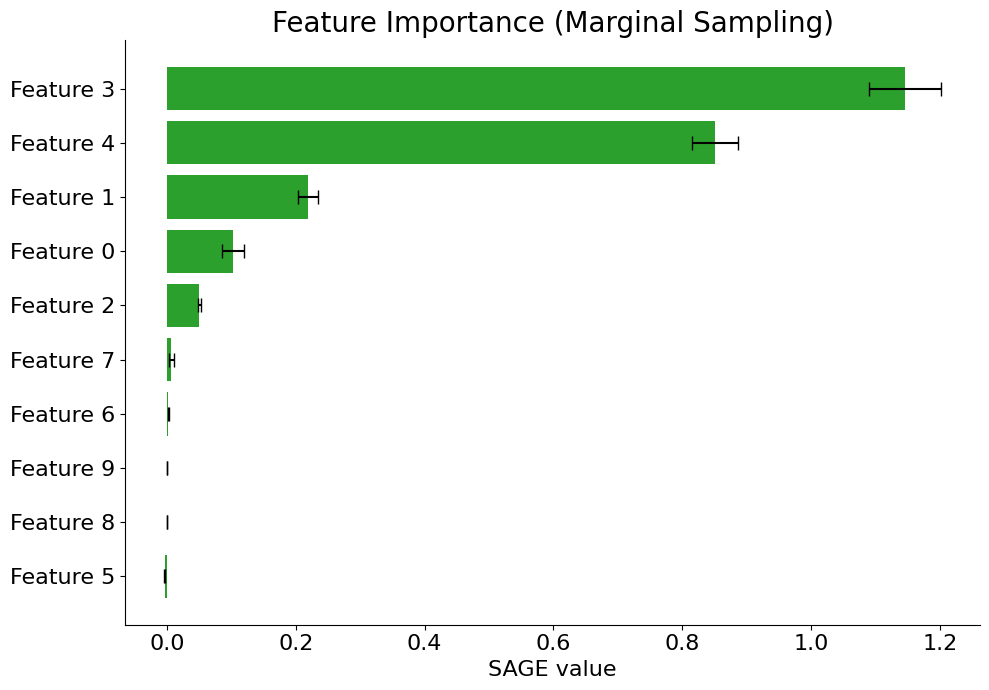

In [7]:
sage_values.plot( title="Feature Importance (Marginal Sampling)")

In [48]:
feature_names = [f"X{i}" for i in range(X_train.shape[1])]
X_train_df = pd.DataFrame(X_train, columns=feature_names)

sampler = GaussianSampler(X_train_df)
wrk = Explainer(cv_full.predict, X_train_df, loss=mean_squared_error, sampler=sampler)

In [ ]:
#mSAGE
ex_msage, orderings = wrk.msage(X_test, y_test, nr_resample_marginalize=50, nr_orderings=40, nr_runs = 3)
ex_msage.ex_name = 'msage'
ex_msage.hbarplot()
plt.show()
df_msage = ex_msage.fi_means_quantiles()
df_msage['type'] = 'mSAGE'

# cSAGE 
ex_csage, orderings = wrk.csage(X_test, y_test, nr_resample_marginalize=50, nr_orderings=40, nr_runs = 3)
ex_csage.ex_name = 'csage'
ex_csage.hbarplot()
plt.show()
df_csage = ex_csage.fi_means_quantiles()
df_csage['type'] = 'cSAGE'

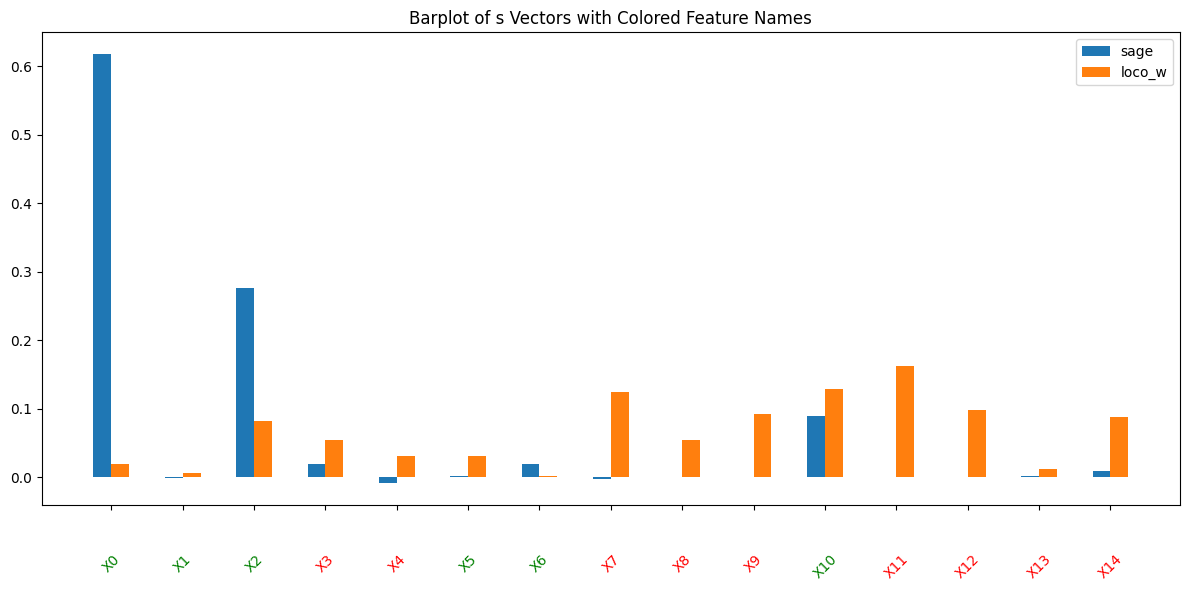

In [42]:
s = 2
methods = ["sage", "loco_w"]
# Stack them
data = np.vstack([sage_values.values, loco_w])

# Feature labels
feature_names = [f'X{i}' for i in range(p)]

# Indices to color green
#green_indices = {0, 1, 2, 5, 6, 10}
green_indices = {0, 1, 2, 3, 4}
# Set bar width and positions
bar_width = 0.25
x = np.arange(15)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each vector
for i in range(s):
    ax.bar(x + i * bar_width, data[i], width=bar_width, label=methods[i])

# Color and rotate x-tick labels
tick_colors = ['green' if i in green_indices else 'red' for i in range(15)]
ax.set_xticks(x + (s - 1) * bar_width / 2)
for i, (label, color) in enumerate(zip(feature_names, tick_colors)):
    ax.text(x[i] + (s - 1) * bar_width / 2, -0.1, label, color=color,
            ha='center', va='top', rotation=45, transform=ax.get_xaxis_transform())

# Remove default x-axis labels
ax.set_xticklabels([])

ax.legend()
ax.set_title("Barplot of s Vectors with Colored Feature Names")
plt.tight_layout()
plt.show()

In [41]:
sage_values.values

array([ 6.18052755e-01, -5.57473015e-04,  2.75856362e-01,  1.99507053e-02,
       -8.53261062e-03,  2.49152257e-03,  1.92325963e-02, -2.23511828e-03,
        0.00000000e+00,  0.00000000e+00,  8.98309860e-02,  9.33823680e-04,
        2.99056671e-04,  2.56475778e-03,  9.22954007e-03])

In [47]:
# Data generation


def sample_gaussian_toeplitz(n, p, rho):
    # Step 1: Create Toeplitz covariance matrix
    cov = toeplitz([rho**i for i in range(p)])
    
    # Step 2: Sample from multivariate normal
    mean = np.zeros(p)
    samples = np.random.multivariate_normal(mean, cov, size=n)
    
    return samples


## create data
n = 10000
p = 2

x = sample_gaussian_toeplitz(n=n, p=p, rho=0.6)
y = x[:,1] + np.random.normal(0, 1, n)

## -------------------------------------------------------------
## preliminary step: get regression estimators
## -------------------------------------------------------------
## use grid search to get optimal number of trees and learning rate
ntrees = np.arange(100, 500, 100)
lr = np.arange(.01, .1, .05)

param_grid = [{'n_estimators':ntrees, 'learning_rate':lr}]

## set up cv objects
cv_full = GridSearchCV(GradientBoostingRegressor(loss = 'squared_error', max_depth = 1), param_grid = param_grid, cv = 5)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)
cv_full.fit(X_train, y_train)

# Best model
model = cv_full.best_estimator_
# Setup and calculate
imputer = sage.MarginalImputer(model, X_train)
estimator = sage.PermutationEstimator(imputer, "mse")
sage_values = estimator(X_test, y_test)

/home/mind/areyerol/.local/miniconda3/lib/python3.12/site-packages/sage/imputers.py:55: RuntimeWarning: using 8000 background samples may lead to slow runtime, consider using <= 1024
  warnings.warn(
100%|██████████| 1/1 [03:03<00:00, 183.21s/it]     


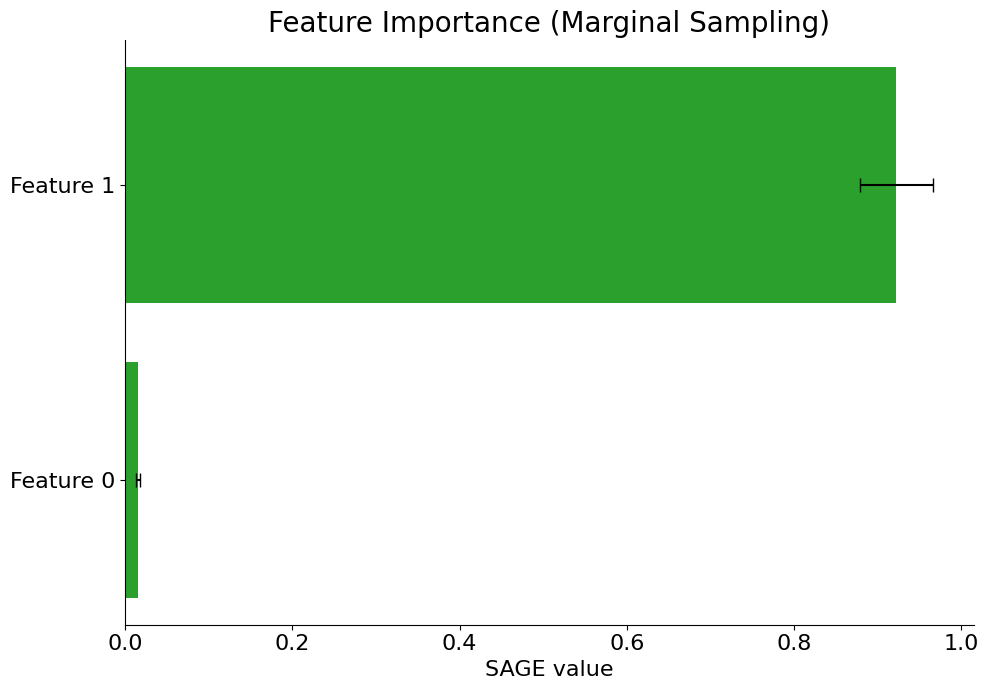

In [49]:
sage_values.plot( title="Feature Importance (Marginal Sampling)")

In [50]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

feature_names = [f"X{i}" for i in range(X_train.shape[1])]
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)
y_test_df = pd.DataFrame(y_test)
y_train_df = pd.DataFrame(y_train)

cv_full.fit(X_train_df, y_train)
 
sampler = GaussianSampler(X_train_df)
wrk = Explainer(cv_full.predict, X_train_df, loss=mean_squared_error, sampler=sampler)

Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find

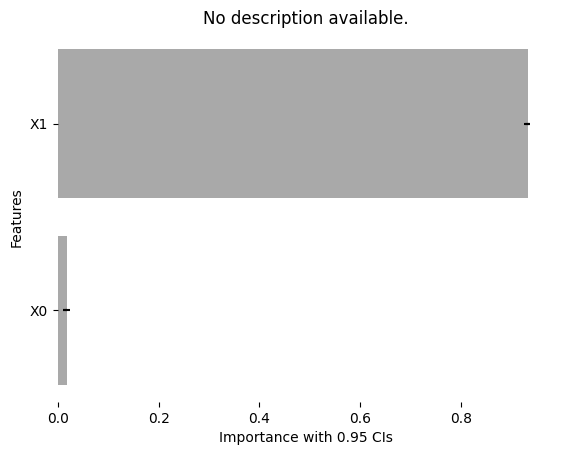

Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find new ordering in 500 runs
Did not find

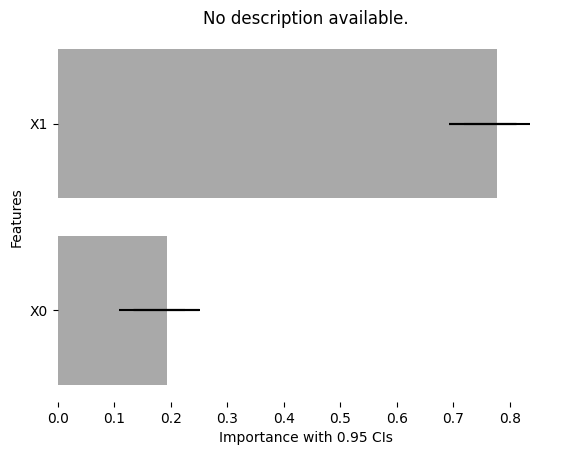

In [51]:
#mSAGE
ex_msage, orderings = wrk.msage(X_test_df, y_test_df, nr_resample_marginalize=50, nr_orderings=40, nr_runs = 3)
ex_msage.ex_name = 'msage'
ex_msage.hbarplot()
plt.show()
#df_msage = ex_msage.fi_means_quantiles()
#df_msage['type'] = 'mSAGE'

# cSAGE 
ex_csage, orderings = wrk.csage(X_test_df, y_test_df, nr_resample_marginalize=50, nr_orderings=40, nr_runs = 3)
ex_csage.ex_name = 'csage'
ex_csage.hbarplot()
plt.show()
#df_csage = ex_csage.fi_means_quantiles()
#df_csage['type'] = 'cSAGE'

In [52]:
ex_msage.fi_means_stds()

X0                                         0.016187
X1                                         0.930984
std    X0    0.002796
X1    0.000780
dtype: float64
dtype: object

In [53]:
ex_csage.fi_means_stds()

X0                                         0.183939
X1                                         0.760272
std    X0    0.014820
X1    0.014772
dtype: float64
dtype: object

In [55]:
flat_array = np.array([
    ex_csage.fi_means_stds()[k] for k in ex_csage.fi_means_stds().index if k != 'std'
])

In [56]:
flat_array

array([0.18393856, 0.76027228])